In [92]:
import pandas as pd
import numpy as np
import random
import time
from datetime import timedelta
from scipy.stats import uniform, randint, norm

from pathlib import Path
import gdown
import joblib
import gc

import matplotlib.pyplot as plt
import matplotlib.colors as mcolors
import seaborn as sns

from sklearn.base import BaseEstimator, TransformerMixin

from sklearn.model_selection import train_test_split,  GridSearchCV, \
    RandomizedSearchCV
from sklearn.preprocessing import StandardScaler, PowerTransformer

from sklearn.feature_selection import SelectFromModel

from sklearn.linear_model import Lasso, LinearRegression
from sklearn.svm import SVR
from sklearn.ensemble import RandomForestRegressor
from xgboost import XGBRegressor

from sklearn.pipeline import Pipeline
from sklearn.multioutput import RegressorChain

from sklearn.metrics import mean_absolute_error, mean_squared_error, r2_score

def random_color():
    """
    get random matplot-lib colour - just for fun
    """
    color_names = list(mcolors.get_named_colors_mapping().keys())
    color_count = len(color_names)
    random_num = random.randint(0, color_count - 1)
    rand_col = mcolors.get_named_colors_mapping()[color_names[random_num]]
    # if rand_col == "No.":
    #     rand_col = random_color()
    return rand_col

### Get Data

In [93]:
PATH_TO_DATA = "C:\\Users\\Peteris\\Documents\\CV\\2025\\shiprojects\\hw_app\\data\\"  # remove after testing
# PATH_TO_DATA = "C:\\Users\\pich\\Documents\\CV\\2025\\shiprojects\\hw_app\\data\\"  # remove after testing
PATH_TO_MODEL = "../models/"
PATH_TO_MODEL = "C:\\Users\\Peteris\\Documents\\CV\\2025\\shiprojects\\hw_app\\models\\"  # remove after testing
# PATH_TO_MODEL = "C:\\Users\\pich\\Documents\\CV\\2025\\shiprojects\\hw_app\\models\\"  # remove after testing
file_name = "test-assignment-dataset.json"
data_url="https://drive.google.com/file/d/1Xx4ozrFDDmzDCuIyUTxjzj43eARpxW1o/view?usp=sharing"

In [94]:
def get_and_load_file(
        data_folder:str="../data/", filename=file_name,
        url:str=data_url)->pd.DataFrame:
    """
    Load JSON dataset into a DataFrame. 
    Download JSON dataset from a Google Drive URL, if not already present.
    :param data_folder: Path to the folder where the file should be stored or loaded from.
    :param filename: Name of the file to check, download, and load.
    :param url: Google Drive URL for downloading the file if it's not found locally.
    :return: A pandas DataFrame containing the data from the JSON file.
    """
    local_file_path = data_folder + filename
    if not Path(local_file_path).is_file():
        print(f"Source data file not present in {data_folder}, downloading file")
        gdown.download(url, local_file_path, fuzzy=True, quiet=False)  # quiet=True after testing
    df = pd.read_json(local_file_path)
    return df

df_source = get_and_load_file(data_folder=PATH_TO_DATA)  # change to default "../data/" after testing
target_columns = ["shaftPower", "speedOverGround"]
df_source.sample(3)

,latitude,longitude,speedOverGround,draught,heading,courseOverGround,status,mainEngineMassFlowRate,mainEngineVolumeFlowRate,mainEngineDensity,...,windWavePeriod,windDirection,windSpeed,airTemperature,salinity,seaLevel,recommendedMassFlowRate,expectedSpeedOverGround,recommendedPower,expectedCarbonIntensityIndicator
234806,53.4860,8.49189,0.0,5.9,208,189.5,5,0.0000,0.000000,864.148,...,2.04,231.0,7.70,6.20,21.09,-1.44,NaN,NaN,NaN,NaN
124388,37.9495,8.46860,10.7,5.9,287,287.9,0,229.7920,0.266723,861.769,...,0.09,94.2,5.62,21.65,37.37,0.01,NaN,NaN,NaN,NaN
11201,51.8378,2.96670,5.0,5.6,80,92.6,0,99.4877,0.119829,830.226,...,2.26,278.4,4.31,19.66,32.91,-0.54,NaN,NaN,NaN,NaN


### EDA

In [95]:
df_source.columns

Index(['latitude', 'longitude', 'speedOverGround', 'draught', 'heading',
       'courseOverGround', 'status', 'mainEngineMassFlowRate',
       'mainEngineVolumeFlowRate', 'mainEngineDensity',
       'mainEngineTemperature', 'mainEngineFuelConsumed',
       'auxEngineMassFlowRate', 'auxEngineVolumeFlowRate', 'auxEngineDensity',
       'auxEngineTemperature', 'shaftSpeed', 'shaftTorque', 'shaftPower',
       'specificFuelOilConsumption', 'timestamp', 'fuelEfficiency',
       'currentDirection', 'currentSpeed', 'gust', 'swellDirection',
       'swellHeight', 'swellPeriod', 'waveDirection', 'waveHeight',
       'wavePeriod', 'windWaveDirection', 'windWaveHeight', 'windWavePeriod',
       'windDirection', 'windSpeed', 'airTemperature', 'salinity', 'seaLevel',
       'recommendedMassFlowRate', 'expectedSpeedOverGround',
       'recommendedPower', 'expectedCarbonIntensityIndicator'],
      dtype='object')

In [96]:
print(df_source.shape)
df_source.info()

(326224, 43)
<class 'pandas.core.frame.DataFrame'>
RangeIndex: 326224 entries, 0 to 326223
Data columns (total 43 columns):
 #   Column                            Non-Null Count   Dtype              
---  ------                            --------------   -----              
 0   latitude                          326222 non-null  float64            
 1   longitude                         326222 non-null  float64            
 2   speedOverGround                   326224 non-null  float64            
 3   draught                           326220 non-null  float64            
 4   heading                           326224 non-null  int64              
 5   courseOverGround                  326222 non-null  float64            
 6   status                            326224 non-null  int64              
 7   mainEngineMassFlowRate            326224 non-null  float64            
 8   mainEngineVolumeFlowRate          326224 non-null  float64            
 9   mainEngineDensity                 3

In [97]:
pd.set_option('display.max_columns', None)
pd.set_option('display.max_colwidth', None)
df_source.describe()

,latitude,longitude,speedOverGround,draught,heading,courseOverGround,status,mainEngineMassFlowRate,mainEngineVolumeFlowRate,mainEngineDensity,mainEngineTemperature,mainEngineFuelConsumed,auxEngineMassFlowRate,auxEngineVolumeFlowRate,auxEngineDensity,auxEngineTemperature,shaftSpeed,shaftTorque,shaftPower,specificFuelOilConsumption,fuelEfficiency,currentDirection,currentSpeed,gust,swellDirection,swellHeight,swellPeriod,waveDirection,waveHeight,wavePeriod,windWaveDirection,windWaveHeight,windWavePeriod,windDirection,windSpeed,airTemperature,salinity,seaLevel,recommendedMassFlowRate,expectedSpeedOverGround,recommendedPower,expectedCarbonIntensityIndicator
count,326222.000000,326222.000000,326224.000000,326220.000000,326224.000000,326222.000000,326224.000000,326224.000000,326224.000000,326224.000000,326224.000000,326224.000000,326224.000000,326224.000000,326224.000000,326224.000000,326224.000000,326224.000000,3.262240e+05,3.262240e+05,170130.000000,308207.000000,308207.000000,326224.000000,317216.000000,317084.000000,317084.000000,308135.000000,319809.000000,305432.000000,316981.000000,316956.000000,317216.000000,326224.000000,326224.000000,326224.000000,326224.000000,326224.000000,42376.000000,42376.000000,4.237600e+04,41735.000000
mean,49.632092,2.978693,4.950242,5.139615,193.701527,184.906974,2.346624,101.245179,0.117942,815.007951,24.161276,1.687420,6.928908,0.007913,831.910785,29.055252,91.172805,25018.630128,4.726122e+05,1.345341e+04,24.023266,175.602391,0.213010,9.238503,231.826153,0.832728,5.962773,200.727807,1.248696,4.953513,195.791109,0.622706,2.573644,191.147175,6.184837,13.429885,32.111769,0.139154,208.732514,10.394949,1.002439e+06,13.708862
std,7.842426,11.030812,5.310358,0.852991,94.737099,101.332097,2.450708,107.507566,0.125246,180.324604,6.350480,1.791793,5.631603,0.006469,89.815379,4.816925,90.952806,26582.660106,5.129609e+05,1.096295e+06,49.499521,97.980663,0.188869,5.095318,94.955289,1.083965,2.736090,89.367433,1.353802,2.578808,89.104112,0.856438,1.822063,90.703968,3.610953,7.193249,5.866357,0.890680,34.060448,1.817699,1.919168e+05,3.732638
min,35.889400,-23.062100,0.000000,3.600000,0.000000,0.000000,0.000000,0.000000,0.000000,-102.695000,-36.085000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000e+00,0.000000e+00,0.000000,0.000000,0.000000,0.480000,0.060000,0.010000,1.370000,0.130000,0.000000,1.270000,0.120000,0.000000,0.000000,0.000000,0.170000,-5.090000,8.500000,-3.650000,117.000000,2.714490,4.536688e+05,6.323664
25%,43.360600,-4.751288,0.000000,4.000000,119.000000,104.700000,0.000000,0.000000,0.000000,844.099000,19.763700,0.000000,0.000000,0.000000,833.019000,25.154087,0.230909,561.959000,1.137835e+01,0.000000e+00,16.982491,92.790000,0.090000,5.140000,168.610000,0.100000,3.970000,138.370000,0.390000,2.920000,133.280000,0.090000,1.450000,116.290000,3.350000,6.690000,30.380000,-0.280000,174.000000,9.030438,8.141896e+05,11.299184
50%,51.623500,3.744930,0.200000,5.600000,207.000000,191.400000,1.000000,0.223440,0.000000,859.116000,25.441300,0.003724,8.562600,0.009678,852.911500,29.616125,1.698130,1839.530000,2.460855e+02,1.509878e+02,19.791990,180.000000,0.150000,8.460000,263.920000,0.500000,5.690000,207.890000,0.810000,4.370000,203.150000,0.360000,2.230000,205.400000,5.330000,14.220000,34.920000,0.070000,200.000000,10.428973,9.676852e+05,12.926036
75%,54.436675,8.506670,10.600000,5.900000,271.000000,270.000000,5.000000,208.348250,0.242225,866.413000,27.714200,3.472471,10.602400,0.012155,863.605000,32.971000,182.396000,50966.000000,9.712270e+05,2.136662e+02,22.387983,259.750000,0.300000,12.870000,308.040000,1.060000,7.930000,276.440000,1.750000,5.990000,260.080000,0.790000,3.420000,255.000000,8.220000,19.260000,35.500000,0.550000,246.000000,11.423510,1.190503e+06,15.216035
max,66.328200,32.230000,17.300000,6.000000,359.000000,359.900000,5.000000,572.696000,0.680159,880.345000,149.950000,9.544933,28.019000,0.046928,875.904500,46.816250,185.733000,94223.400000,1.796530e+06,2.832681e+08,3176.

In [98]:
pd.reset_option('all')

C:\Users\Peteris\AppData\Local\Temp\ipykernel_16504\2786130087.py:1: FutureWarning: data_manager option is deprecated and will be removed in a future version. Only the BlockManager will be available.
  pd.reset_option('all')
C:\Users\Peteris\AppData\Local\Temp\ipykernel_16504\2786130087.py:1: FutureWarning: use_inf_as_na option is deprecated and will be removed in a future version. Convert inf values to NaN before operating instead.
  pd.reset_option('all')


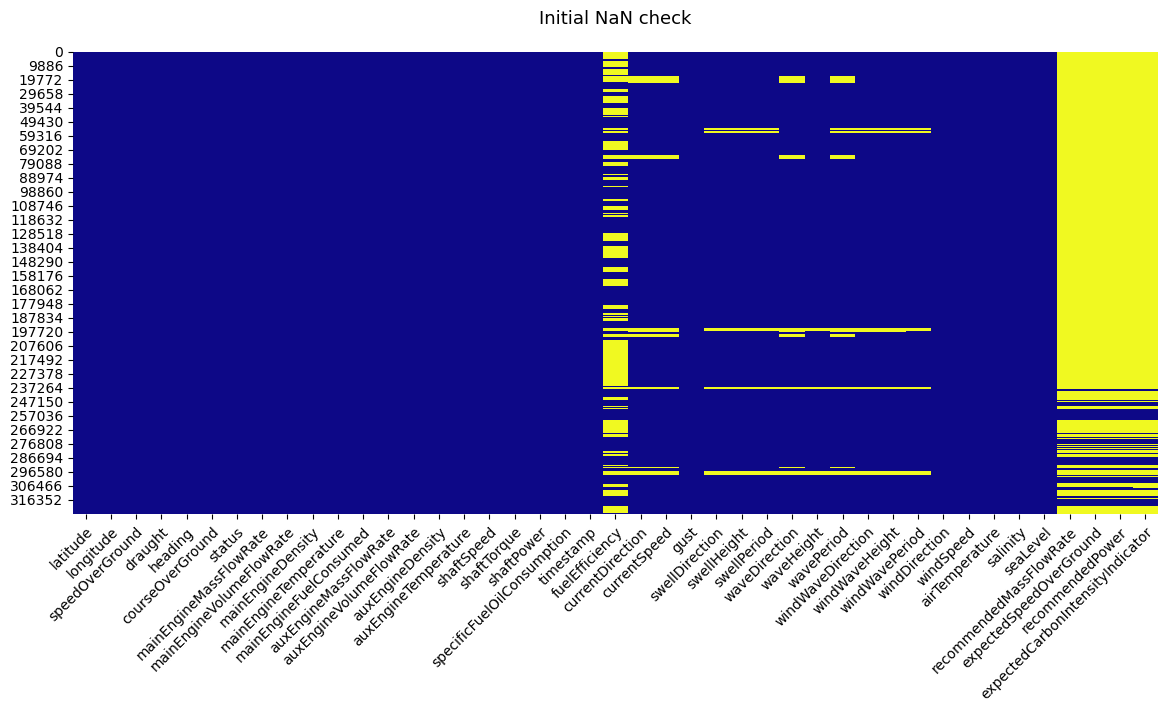

In [99]:
plt.figure(figsize=(df_source.shape[1] // 3, 6))
sns.heatmap(df_source.isnull(), cmap='plasma', cbar=False)
plt.title("Initial NaN check\n", 
          fontsize=13)
plt.xticks(rotation=45, ha='right', rotation_mode='anchor')
plt.show()

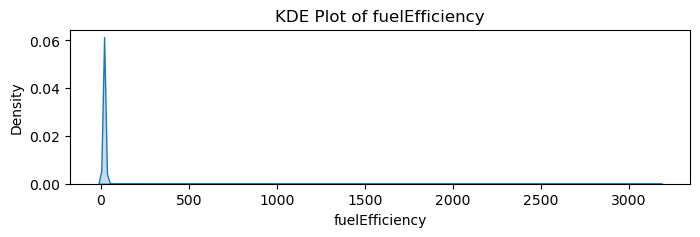

In [100]:
plt.figure(figsize=[8, 2])
sns.kdeplot(data=df_source['fuelEfficiency'].dropna(), fill=True)
plt.title('KDE Plot of fuelEfficiency')
plt.xlabel('fuelEfficiency')
plt.ylabel('Density')
plt.show()

In [101]:
df_source['fuelEfficiency'].value_counts(dropna=True, ascending=False, normalize=True).head(5)

fuelEfficiency
0.00     0.065826
20.55    0.000035
18.66    0.000029
19.74    0.000024
16.52    0.000024
Name: proportion, dtype: float64

In [102]:
nan_rows = df_source[df_source.loc[:, 'currentDirection':'seaLevel'].isnull().any(axis=1)].index  # rows, where specified columns contain NaNs
print(f"proportion of rows containing nan values in selected rows ('currentDirection':'seaLevel') \
against entire dataset:\n{round(len(nan_rows)/df_source.shape[0]*100, 1)}%")

proportion of rows containing nan values in selected rows ('currentDirection':'seaLevel') against entire dataset:
6.4%


In [103]:
print(f"Correlation between sparsely populated 'expected' and 'registered' speeds over ground:\
    {df_source["speedOverGround"].corr(df_source["expectedSpeedOverGround"])}")
print(f"Correlation between sparsely populated 'recommended' and 'registered' mass flow rates:\
    {df_source["mainEngineMassFlowRate"].corr(df_source["recommendedMassFlowRate"])}")
print(f"Correlation between sparsely populated 'recommended' and 'registered' power:\
    {df_source["shaftPower"].corr(df_source["recommendedPower"])}")


Correlation between sparsely populated 'expected' and 'registered' speeds over ground:    0.30263690090074735
Correlation between sparsely populated 'recommended' and 'registered' mass flow rates:    0.5643054263353686
Correlation between sparsely populated 'recommended' and 'registered' power:    0.6290641912284795


In [104]:
def display_distributions(data: pd.DataFrame, features: list[str], 
                          title_prefix: str=None):
    """Display distribution graphs for specified categorical columns.
    Graphs are displayed as a vertical stack of box plots.
    :param data: DataFrames with numerical categories for visualization.
    :param features: list of column names/features  from 'data' Dataframe.
    :param title_prefix: Optional, prefix for visualization title.
    """
    n_subplots = len(features) * 2
    fig, axs = plt.subplots(nrows=n_subplots, figsize = (15,n_subplots*2))
    index = 0
    for feature in features:
        sns.boxenplot(data=data,
                      x=data[feature], color=random_color(), ax=axs[index])
        sns.kdeplot(data=data,
                      x=data[feature], color=random_color(), ax=axs[index+1])
        index += 2
        
    if title_prefix:
        fig.suptitle(f"{title_prefix} feature distribution analysis", fontsize=18)
    else:
        fig.suptitle(f"Features distribution analysis", fontsize=18)
    fig.tight_layout()

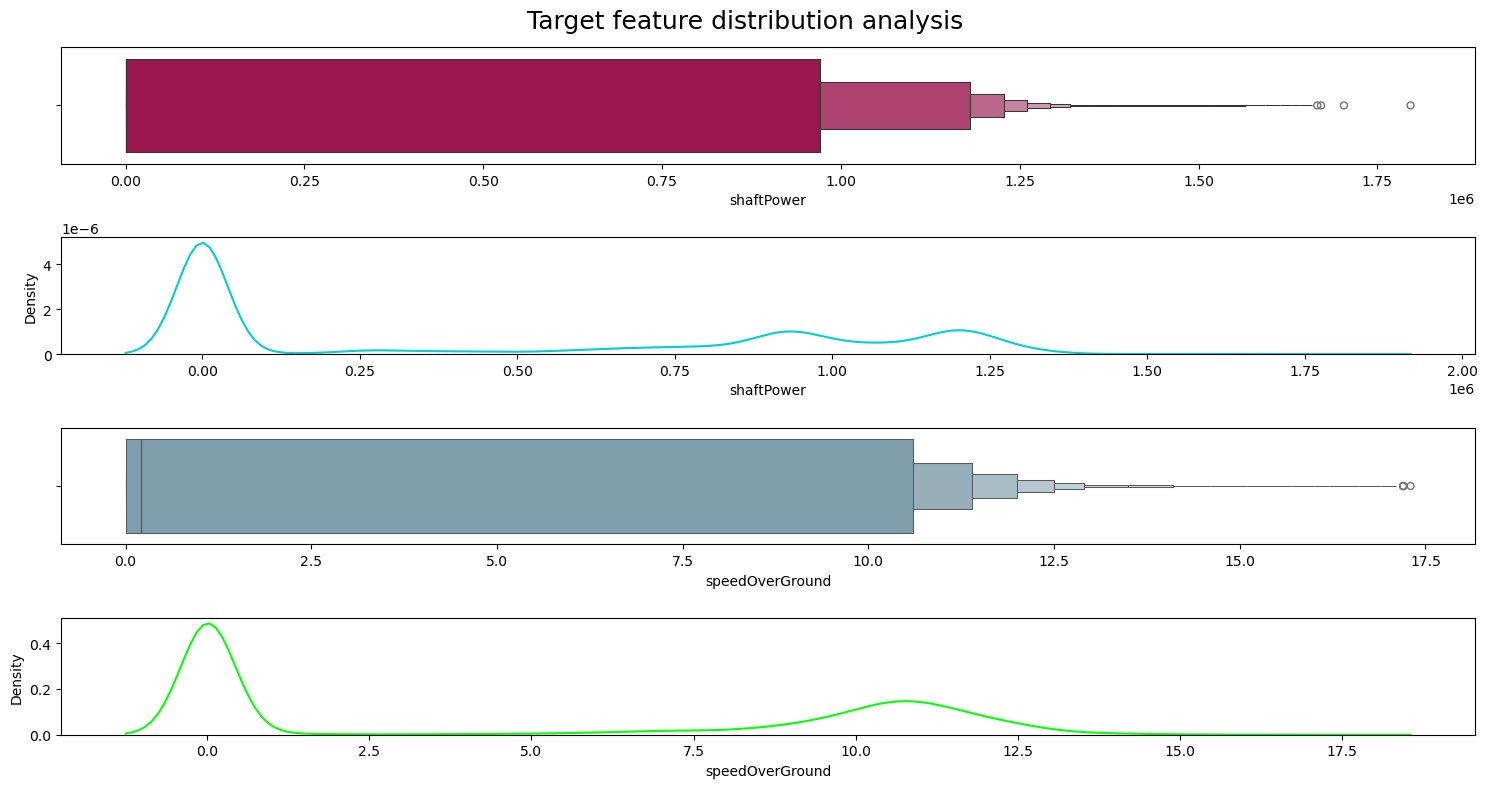

In [105]:
display_distributions(
    data=df_source,
    features=target_columns, title_prefix="Target")

#### Experiments with log and box-cox transformation to improve target distributions (uncomment if wish to see results):

In [106]:
# df_log = df_source.copy()
# df_log[target_columns] = np.log1p(df_log[target_columns])

In [107]:
# display_distributions(
#     data=df_log,
#     features=target_columns, title_prefix="Log transformed Target")

In [108]:
# df_yeo = df_source.copy()
# pt = PowerTransformer(method='box-cox')
# df_yeo[target_columns] = pt.fit_transform(df_yeo[target_columns] + 1e-5)

In [109]:
# display_distributions(
#     data=df_yeo,
#     features=target_columns, title_prefix="Box-Cox transformed Target")

- #### With only ~6% of rows containing missing values for weather data, I will delete them in training task:
    - To decide on best imputation strategy for missing environmental data (weather, sea conditions) domain expert is needed on:
        - whether mean/mode imputation is sufficient
        - Does dataset structure (eg row sequence, timestamp) has sufficient for k-neighbors imputation
        - does other columns are sufficient predictors to use regression imputation
- #### Drop sparsely populated 'expected' and 'recommended' engine data features:
    - Correlations between 'expected'/'recommended' features range wro weak to strong.
    - Thus some of them could be useful for model training.
    - However, cleaning up their missing values is not feasible unless these features have particular importance according to domain expert opinion (missing in this exercise).
- #### Replace 'fuelEfficiency' NaNs with zeroes as it is most popular value among "good" entries for the feature anyway
- #### Both targets `shaftPower` and `speedOverGround` are right skewed, multimodal with medians approaching zero. `shaftPower` has outliers in range exceeding 1.5 MW:
    - remove rows containing outlier data in `shaftPower`.
    - Considered log or Yeo-Johnson transformation for `shaftPower` due to zero median, skewness and multimodality. None of the two solved multimodality problem. However, tree/ensemble should handle multimodality reasonably well.

### Data Preprocessing

In [110]:
def clean_data(data:pd.DataFrame, nan_col_start:str = "latitude",
               nan_col_end:str = "seaLevel", cols_to_dorp:list[str] = [
                   "recommendedMassFlowRate",
                   "expectedSpeedOverGround",
                   "recommendedPower",
                   "expectedCarbonIntensityIndicator",
                   ],
               nan_to_zero_columns:list[str] = ["fuelEfficiency"],
               outlier_removal:list[tuple]=None, 
               )->pd.DataFrame:
    """
    Clean and preprocess the dataset for modeling:
    1) Create a deep copy of the input dataset to preserve the original data.
    2) Fill missing values in the specified columns with 0.
    3) Identify and drop rows with any NaN values between specified columns (inclusive).
    4) Remove predefined columns unrelated to model input.
    5) Drop columns that contain single unique value (not useful for ML algorithm).
    6) Remove outlier rows for specified columns within specified percentile range.
    3) convert all numeric columns to pd.Series compatible float32 for resource 
            saving and scikit learn compatibility (e.g. RegressorChain).

    :param data: Input DataFrame to be cleaned.
    :param nan_col_start: Column name where NaN checking should begin (inclusive).
    :param nan_col_end: Column name where NaN checking should end (inclusive).
    :param nan_to_zero_columns: specify al list of columns where NaN values will be replaced by 0.
    :param outlier_removal: list of tuples that consist of column name, lower and upper 
                                percentile (float) for outlier row removal.
    :return: A cleaned DataFrame with rows and columns filtered and missing data handled.
    """
    df_new = data.copy(deep=True)
    if nan_to_zero_columns:
        for column in nan_to_zero_columns:
            df_new[column] = df_new[column].fillna(0)
    nan_rows = df_new[df_new.loc[:, nan_col_start:nan_col_end].isnull().any(axis=1)].index
    df_new = df_new.drop(index=nan_rows)
    df_new = df_new.drop(columns=cols_to_dorp)

    df_new = df_new.drop(columns=[col for col in df_new.columns 
                                  if df_new[col].nunique(dropna=False) == 1])

    if outlier_removal:
        for  feature, lower, upper in outlier_removal:
            df_new = df_new[(df_new[feature] >= df_new[feature].quantile(lower)) 
                            & (df_new[feature] <= df_new[feature].quantile(upper))]
            
    numeric_cols = df_new.select_dtypes(include=np.number).columns
    df_new[numeric_cols] = df_new[numeric_cols].astype(np.float32)

    return df_new

df_clean = clean_data(df_source,
                      outlier_removal=[("shaftPower", 0, 0.999)]
                      )
df_clean.shape

(305120, 39)

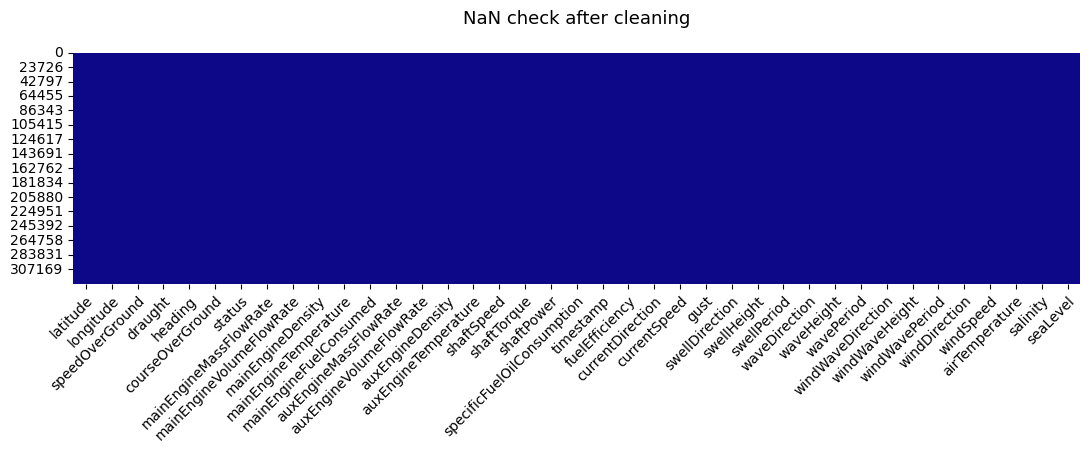

In [111]:
plt.figure(figsize=(df_clean.shape[1] // 3, 3))
sns.heatmap(df_clean.isnull(), cmap='plasma', cbar=False)
plt.title("NaN check after cleaning\n", 
          fontsize=13)
plt.xticks(rotation=45, ha='right', rotation_mode='anchor')
plt.show()

### Feature Selection 

In [112]:
f"Dates in 'timestamp' feature range from {min(df_clean["timestamp"])} to {max(df_clean["timestamp"])}."

"Dates in 'timestamp' feature range from 2024-07-26 10:24:00+00:00 to 2025-03-12 23:59:00+00:00."

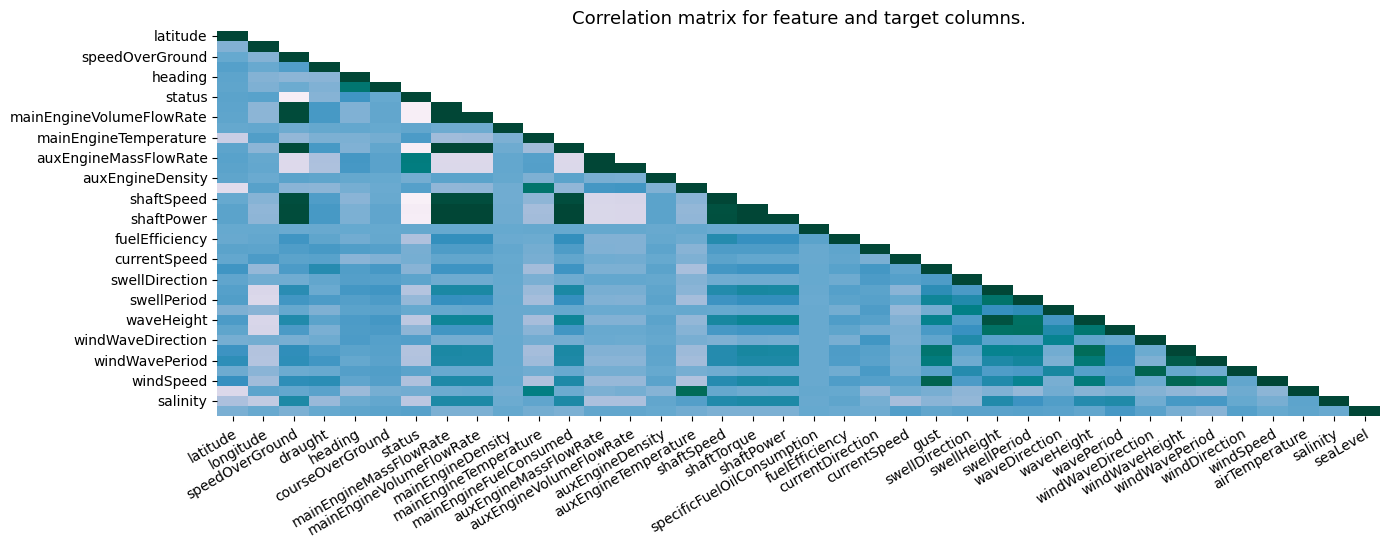

In [113]:
def compute_correlations_matrix(data=df_clean):
    """
    Compute and display a heatmap of the correlation matrix for numerical features.    
    :param dataset: pandas DataFrame containing the input data.
    :return: pandas DataFrame of the correlation matrix.
    """
    plt.figure(figsize=(15, 5))
    correlation_matrix = data.select_dtypes(include='number').corr()
    triangular_matrix = np.triu(correlation_matrix, k=1)

    sns.heatmap(
      data=correlation_matrix,
      center=0,
      cmap= 'PuBuGn',
      cbar=False,
      annot=False,
      mask=triangular_matrix
    )
    plt.xticks(rotation=30,ha='right', rotation_mode="anchor")
    plt.title("Correlation matrix for feature and target columns.", fontsize=13);
    return correlation_matrix


correlations = compute_correlations_matrix(df_clean)

In [114]:
def top_correlations(data:pd.DataFrame=df_clean, corr_threshold:float=0.95)->pd.Series:
    """
    Identify and return highly correlated feature pairs above a specified threshold.
    :param data: pandas DataFrame containing the input dataset. Defaults to df_clean.
    :param corr_threshold: Correlation threshold to filter feature pairs. Default is 0.95.
    :return: A pandas Series with multi-index (feature pairs) and correlation values.
    """
    corrs = data.select_dtypes(include='number').corr()
    corrs = corrs.unstack().sort_values(ascending=False)
    corrs = corrs[(corrs.abs() > corr_threshold) & 
                        (corrs.index.get_level_values(0) != corrs.index.get_level_values(1))]
    corrs = corrs.drop_duplicates()
    return corrs

sorted_corr = top_correlations()

print(f"Features with correlation exceeding 0.95:")
sorted_corr

Features with correlation exceeding 0.95:


mainEngineFuelConsumed    mainEngineMassFlowRate      1.000000
shaftPower                shaftTorque                 0.999864
mainEngineVolumeFlowRate  mainEngineFuelConsumed      0.999709
mainEngineMassFlowRate    mainEngineVolumeFlowRate    0.999709
auxEngineMassFlowRate     auxEngineVolumeFlowRate     0.998790
shaftPower                mainEngineFuelConsumed      0.997489
mainEngineMassFlowRate    shaftPower                  0.997489
shaftPower                mainEngineVolumeFlowRate    0.997246
mainEngineFuelConsumed    shaftTorque                 0.996993
shaftTorque               mainEngineMassFlowRate      0.996993
mainEngineVolumeFlowRate  shaftTorque                 0.996629
                          speedOverGround             0.962003
speedOverGround           mainEngineMassFlowRate      0.961377
mainEngineFuelConsumed    speedOverGround             0.961377
speedOverGround           shaftPower                  0.954996
                          shaftTorque                 0

### Conclusion: multicollinearity detected, conduct feature selection:
- #### 	Drop/Combine/Regularize if linear (including ridge or lasso) or even SVM regressions used
- #### feature still selection recommended for tree based or Gradient Boosting models
- #### Will drop drop potentially derived or redundant features:
    - #### `mainEngineFuelConsumed`: Possibly a computed value from mass flow
    - #### `shaftTorque`: derived from `mainEngineMassFlowRate` and target `shaftPower`
    - #### 	`auxEngineVolumeFlowRate` and `mainEngineVolumeFlowRate`: Volume flow might be calculated from mass flow
    - #### `mainEngineFuelConsumed`: same as `mainEngineMassFlowRate` measures fuel movement

In [115]:
class FeatureSelector(BaseEstimator, TransformerMixin):
    """
    Remove selected features (columns) from the input DataFrame.
    Inherits from scikit-learn's BaseEstimator and TransformerMixin 
            for scikit-learn pipeline compatibility.
     Used to simplify datasets by excluding specified columns during preprocessing.
    :param data: pandas DataFrame to process. Defaults to df_clean.
    :param features_to_drop: List of column names to drop.
    """

    def __init__(self, features_to_drop:list=None):
        """"
        Initialize with the provided data and feature configurations.
        Store the list of features to drop for later use in transformation.
        """
        self.features_to_drop = features_to_drop


    def fit(self, X, y=None):
        """
        Fit method for compatibility with scikit-learn pipelines.
        Does not perform any fitting operation.
        """
        return self
    

    def transform(self, X: pd.DataFrame, feature_to_drop:list=None)->pd.DataFrame:
        """
        Remove specified features (columns) from the input DataFrame.
        Uses instance-level 'features_to_drop' unless an override list is provided.
        :param X: input data.
        :param features_to_drop: List of column names to drop.
        :return: A new pandas DataFrame with the specified features removed.
        """
        df_new = X.copy(deep=True)
        features = feature_to_drop or self.features_to_drop
        if features:
            df_new = df_new.drop(columns=features)
            
        return df_new

In [116]:
collinear_features=[
    "mainEngineFuelConsumed",
    "shaftTorque", 
    "auxEngineVolumeFlowRate", 
    "mainEngineVolumeFlowRate",
    ]

feature_selector = FeatureSelector(features_to_drop=collinear_features)

df_feat_sel = feature_selector.transform(X=df_clean)
df_feat_sel.shape

(305120, 35)

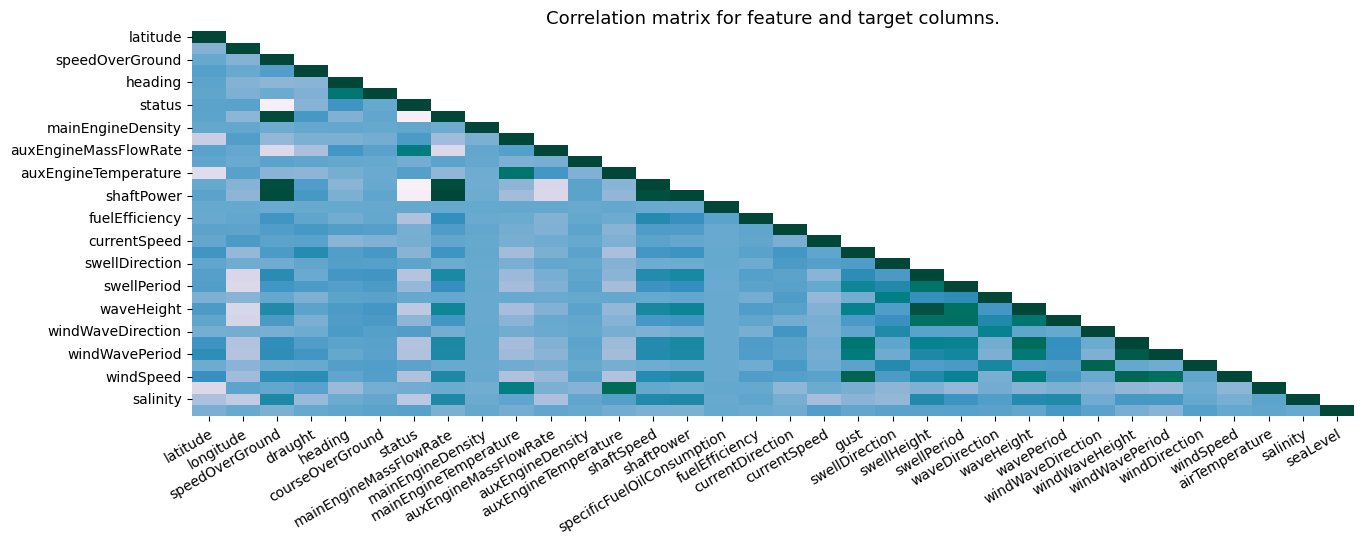

In [117]:
correlations = compute_correlations_matrix(df_feat_sel)

In [118]:
# Remove after testing
correlations_threshold = 0.95
sorted_corr_f = top_correlations(data=df_feat_sel, corr_threshold=correlations_threshold)

print(f"Features with correlation exceeding {correlations_threshold}:")
sorted_corr_f

Features with correlation exceeding 0.95:


shaftPower       mainEngineMassFlowRate    0.997489
speedOverGround  mainEngineMassFlowRate    0.961377
shaftPower       speedOverGround           0.954996
dtype: float64

**Conclusion**: High correlations remaining are target features and `mainEngineMassFlowRate` identified as must-have by task description. Thus those will remain.

### Feature Engineering

In [ ]:
class FeatureEngineer(BaseEstimator, TransformerMixin):
    """
    Engineer features: angular, force interaction and time.
    Inherits from scikit-learn's BaseEstimator and TransformerMixin 
            for scikit-learn pipeline compatibility.
    :param angular_features: List of angle-based feature column names (in degrees).
    :param env_force_features: List of (angle feature, force feature) pairs for decomposing forces.
    :param base_angle_feats: Reference angle column name (default, 'heading').
    :param base_time_feats: Column name for timestamp (default, 'timestamp').
    :param drop_original_features: Flag to optionally remove original features aself.base_angle_featt 
                                    class level with 'transform()' method.
    """


    def __init__(self,
                 angular_features: list[str] = None,
                 env_force_features: list[tuple] = None,
                 base_angle_feats: str = "heading",
                 base_time_feats: str = "timestamp",
                 drop_original_features: bool = False
                 ):
        """
        Initialize with the provided data and feature configurations.
        Store configuration parameters for use in transformations.
        """
        self.angular_features = angular_features or []
        self.env_force_features = env_force_features or []
        self.base_angle_feats = base_angle_feats
        self.base_time_feats = base_time_feats
        self.drop_original_features = drop_original_features
        self._transformed_feature_names = None


    def fit(self, X: pd.DataFrame, y=None):
        """
        Fit method for compatibility with scikit-learn pipelines.
        Does not perform any fitting operation.
        """
        if hasattr(X, "columns"):
            self.feature_names_in_ = X.columns
        else:
            self.feature_names_in_ = None

        return self
    
    
    @property
    def feature_names_out_(self):
        """
        Getter for feature names after transformations.
        If transformations have been applied, return the column names.
        """
        # if self._transformed_feature_names is None:
        #     # We need to transform the input once to gather feature names
        #     # Temporarily perform the transformation to get the feature names
        #     transformed_df = self.transform(X=pd.DataFrame(columns=X.columns))
        #     self._transformed_feature_names = transformed_df.columns.tolist()
        return self._transformed_feature_names
    

    @staticmethod
    def compute_relative_angle(angle1, angle2):
        """
        Compute absolute minimal angle difference between two angles (in degrees).
        :param angle1: First angle or Series of angles.
        :param angle2: Second angle or Series of angles.
        :return: Absolute minimal angular difference in degrees.
        """
        return np.abs(((angle1 - angle2 + 180) % 360) - 180)
    

    @staticmethod
    def drop_columns(data:pd.DataFrame, drop_list:list[str]):
        """
        Drop specified columns from the DataFrame.
        Check for presence of 'drop_list' features in DataFrame.
        :param data: DataFrame to modify.
        :param drop_list: List of column names to drop.
        :return: Modified DataFrame with columns removed.
        """
        data.drop(
            columns=[col for col in drop_list if col in data.columns],
            errors='ignore',
            inplace=True
            )
        
        return data


    def transform_angles(self,
                        X: pd.DataFrame,
                        angular_feature: list[str] = None,
                        drop_source_feature: bool = False) -> pd.DataFrame:
        """
        Compute relative angles between angular features and base_angle_feat.
        This feature provides if various external forces (current, wind, etc) facilitate 
            or counteract ship's course.
        If not specified otherwise, use parameters defined at 'FeatureEngineer' initialization.
        Check for duplicated columns and drop if any are created via multiple method calls.
        Optionally drop original columns.
        :param X: input data.
        :param angular_feature: List of angle-based feature column names (in degrees).
        :param drop_source_feature: Flag to drop original angle columns (default, False).
        :return: DataFrame with added relative angle features.
        """
        df_angle = X.copy(deep=True)
        features = angular_feature or self.angular_features

        for angle_feature in features:
            if angle_feature in df_angle.columns\
                and self.base_angle_feats in df_angle.columns:
                angle_to_heading = self.compute_relative_angle(
                    df_angle[angle_feature], df_angle[self.base_angle_feats])

                df_angle.insert(loc=df_angle.columns.get_loc(angle_feature) + 1,
                                column=angle_feature + '_rel_head',
                                value=angle_to_heading,
                                allow_duplicates=True)
                
        df_angle = df_angle.loc[:, ~df_angle.columns.duplicated()]  
        if drop_source_feature:
            df_angle = self.drop_columns(data=df_angle, drop_list=features+[self.base_angle_feats])
   
        return df_angle


    def transform_force_components(self,
                                   X: pd.DataFrame,
                                   env_force_feature: list[tuple] = None,
                                   drop_source_feature: bool = False) -> pd.DataFrame:
        """
        Add force features based on relative angle to base_angle_feat.
        This feature provides index for external forces (current, wind, etc) speed and angle
             counteracting ship's course. Higher index means stronger tail/cross components.
        If not specified otherwise, use parameters defined at 'FeatureEngineer' initialization.
        Check for duplicated columns and drop if any are created via multiple method calls.
        Optionally drop original columns.
        :param X: input data.
        :param env_force_feature: List of (angle_col, force_col) pairs for decomposing forces.
        :param drop_source_feature: Flag to drop original force columns (default, False).
        :return: DataFrame with new force features.
        """
        df_force = X.copy(deep=True)
        features = env_force_feature or self.env_force_features

        for angle_col, force_col in features:
            if angle_col in df_force.columns\
            and force_col in df_force.columns\
            and self.base_angle_feats in df_force.columns:
                rel_angle_rad = np.radians(
                    self.compute_relative_angle(
                        df_force[angle_col], df_force[self.base_angle_feats]))
                idx_force = df_force.columns.get_loc(force_col)

                df_force.insert(loc=idx_force + 1,
                                column=force_col + "_head",
                                value=df_force[force_col] * np.cos(rel_angle_rad),
                                allow_duplicates=True)

                # Insert cross-wind/current component
                df_force.insert(loc=idx_force + 1,
                                column=force_col + "_cross",
                                value=df_force[force_col] * np.sin(rel_angle_rad),
                                allow_duplicates=True)
            
                if drop_source_feature:
                    df_force = self.drop_columns(data=df_force, drop_list=[angle_col, force_col])
            
        df_force = df_force.loc[:, ~df_force.columns.duplicated()]
                
        return df_force
    

    def eng_direction_features(self,
                               X: pd.DataFrame, 
                                angular_feature: list[str] = None,
                                drop_source_feature: bool=False
                                )->pd.DataFrame:
        """
        Engineer sine and cosine components of directional features to preserve circularity.
        New sine and cosine features address issue arising from circularity of angle features
                     - e.g. that after 360 comes 0.
        If not specified otherwise, use parameters defined at 'FeatureEngineer' initialization.
        Check for duplicated columns and drop if any are created via multiple method calls.
        Optionally drop original columns.
        :param X: input data.
        :param angular_feature: List of directional feature columns (in degrees).
        :param drop_source_feature: Flag to drop original direction columns (default, False).
        :return: DataFrame with sine and cosine of directional features.
        """
        df_direction = X.copy(deep=True)
        features = angular_feature or self.angular_features

        for angle_feature in features:
            if angle_feature in df_direction.columns\
                and self.base_angle_feats in df_direction.columns:
                orig_feat_index = df_direction.columns.get_loc(angle_feature)
                df_direction.insert(loc=orig_feat_index+1,
                                    column=angle_feature+'_sin',
                                    value=np.sin(2 * np.pi * df_direction[angle_feature] / 360),
                                    # value=np.sin(np.radians(df_direction[feature])),
                                    allow_duplicates=True)
                df_direction.insert(loc=orig_feat_index+1,
                                    column=angle_feature+'_cos',
                                    value=np.cos(2 * np.pi * df_direction[angle_feature] / 360),
                                    # value=np.cos(np.radians(df_direction[feature])),
                                    allow_duplicates=True)

        if drop_source_feature:
            df_direction = self.drop_columns(data=df_direction, drop_list=features)
        df_direction = df_direction.loc[:, ~df_direction.columns.duplicated()]

        return df_direction
    

    def eng_circular_time_feats(self,
                                X: pd.DataFrame,
                                base_time_feat: str = None,
                                ):
        """
        Create hour and month features from timestamp. 
        Both potentially indicate daily or seasonal weather patterns 
                    affecting ship's speed and engine workloads.
        Calculate sines and cosines to preserve circularity - e.g. that after 23 or 12 comes 0/1.
        If not specified otherwise, use parameters defined at 'FeatureEngineer' initialization.
        Assumes datetime data type for timestamp column.
        Check for duplicated columns and drop if any are created via multiple method calls.
        Drop original column as most models will not process timestamp objects.
        :param X: input data.
        :param base_time_feat: Column name containing time information (default, None).
        :param drop_source_feature: Flag to drop original timestamp columns (default, False).
        :return: DataFrame with sine and cosine components of the hour feature.
        """
        df_time = X.copy(deep=True)
        time_feature = base_time_feat or self.base_time_feats
        if time_feature in df_time.columns and pd.api.types.is_datetime64_any_dtype(df_time[time_feature]):
            idx_time = df_time.columns.get_loc(time_feature)
            new_time_features = [("hours", df_time[time_feature].dt.hour, 24),
                                 ("months", df_time[time_feature].dt.month, 12)]

            for name, values, circular_divisor in new_time_features:
                df_time.insert(loc=idx_time+1,
                                    column=name + "_sin",
                                    value=np.sin(2 * np.pi * values / circular_divisor),
                                    allow_duplicates=True)
                df_time.insert(loc=idx_time+1,
                                    column=name + "_cos",
                                    value=np.cos(2 * np.pi * values / circular_divisor),
                                    allow_duplicates=True)
            df_time = self.drop_columns(df_time, [time_feature])

        return df_time


    def transform(self, X:pd.DataFrame) -> pd.DataFrame:
        """
        Apply transformations to angles, forces, directions, and power-to-speed ratio.
        Calls all 'FeatureEngineer' feature engineering steps sequentially and removes duplicates.
        Uses 'FeatureEngineer' instance-level 'drop_original_features' flag to remove original features.
        :param X: input data.
        :return: Transformed DataFrame with engineered features.
        """
        if not hasattr(X, "columns"):
            df = pd.DataFrame(X, columns=self.feature_names_in_)
        elif isinstance(X, pd.DataFrame):
            df = X.copy(deep=True)
        df = self.transform_angles(X=df)
        df = self.transform_force_components(X=df, drop_source_feature=self.drop_original_features)
        df = self.eng_direction_features(X=df, drop_source_feature=self.drop_original_features)
        df = self.eng_circular_time_feats(X=df)
        if self.drop_original_features is not False:
            df = self.drop_columns(data=df, drop_list=[self.base_angle_feats])
        df = df.loc[:, ~df.columns.duplicated()]
        self._transformed_feature_names = df.columns.tolist()

        return df

In [134]:
engineer = FeatureEngineer(
    angular_features=[
        "windDirection",
        "currentDirection",
        "waveDirection",
        "swellDirection",
        "windWaveDirection"
        ],
    env_force_features=[
        ("windDirection","windSpeed"),
        ("currentDirection", "currentSpeed")
        ],
    drop_original_features=False,
)
df_feat_eng = engineer.transform(X=df_feat_sel)
df_feat_eng.columns

Index(['latitude', 'longitude', 'speedOverGround', 'draught', 'heading',
       'courseOverGround', 'status', 'mainEngineMassFlowRate',
       'mainEngineDensity', 'mainEngineTemperature', 'auxEngineMassFlowRate',
       'auxEngineDensity', 'auxEngineTemperature', 'shaftSpeed', 'shaftPower',
       'specificFuelOilConsumption', 'months_cos', 'months_sin', 'hours_cos',
       'hours_sin', 'fuelEfficiency', 'currentDirection',
       'currentDirection_cos', 'currentDirection_sin',
       'currentDirection_rel_head', 'currentSpeed', 'currentSpeed_cross',
       'currentSpeed_head', 'gust', 'swellDirection', 'swellDirection_cos',
       'swellDirection_sin', 'swellDirection_rel_head', 'swellHeight',
       'swellPeriod', 'waveDirection', 'waveDirection_cos',
       'waveDirection_sin', 'waveDirection_rel_head', 'waveHeight',
       'wavePeriod', 'windWaveDirection', 'windWaveDirection_cos',
       'windWaveDirection_sin', 'windWaveDirection_rel_head', 'windWaveHeight',
       'windWavePeri

In [121]:
df_feat_eng.sample(1)

,latitude,longitude,speedOverGround,draught,courseOverGround,status,mainEngineMassFlowRate,mainEngineDensity,mainEngineTemperature,auxEngineMassFlowRate,...,windWaveDirection_sin,windWaveDirection_rel_head,windWaveHeight,windWavePeriod,windDirection_rel_head,windSpeed_cross,windSpeed_head,airTemperature,salinity,seaLevel
158312,39.848202,8.46153,0.1,3.8,278.299988,1.0,0.0,853.866028,27.944099,8.5347,...,-0.908872,97.350006,0.0,0.0,48.730011,1.939153,1.701789,16.620001,37.610001,0.1


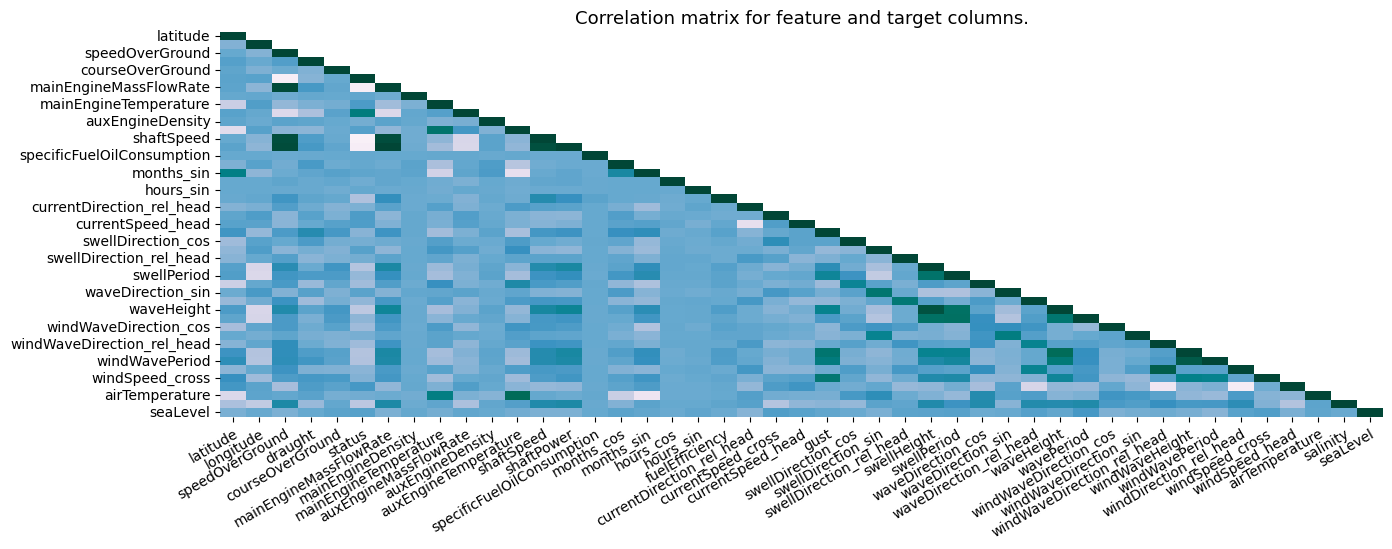

In [122]:
correlations = compute_correlations_matrix(df_feat_eng)

In [123]:
correlations_threshold = 0.90
sorted_corr_f = top_correlations(data=df_feat_eng, corr_threshold=correlations_threshold)

print(f"Features with correlation exceeding {correlations_threshold}:")
sorted_corr_f

Features with correlation exceeding 0.9:


shaftPower              mainEngineMassFlowRate    0.997489
mainEngineMassFlowRate  speedOverGround           0.961377
speedOverGround         shaftPower                0.954996
shaftSpeed              mainEngineMassFlowRate    0.945977
                        speedOverGround           0.937545
                        shaftPower                0.926743
swellHeight             waveHeight                0.914593
status                  shaftSpeed               -0.913061
dtype: float64

In [124]:
X_train, X_test, y_train, y_test = train_test_split(
    df_clean.drop(columns=target_columns),
    df_clean[target_columns],
    test_size=0.2,
    random_state=42)

### Model Selection

#### Training and Evaluation:
- #### Create 2 datasets and run models on them:
    - with original and multicollinear features for trees/ensembles.
    - without or original features and target distribution transformation for all test models.
    - as well as experiment with Lasso feature selection for linear models.

In [125]:
def evaluation_tabel(
        predictions: np.ndarray,
        y_true: pd.DataFrame = y_test,    
        target_index: list[str] = target_columns,
        original_dataset_correlations: pd.Series= None,
        ) -> pd.DataFrame:
    """
    Get model evaluation table with MAE, RMSE and R2 metrics.
    MAPE calculation excludes all 0 values for True values.
    Optionally add highest correlation scores between target and source features.
    :param y_true: target data with true values.
    :param predictions: model predictions.
    :param target_index: names of target labels.
    :param original_dataset_correlations: correlation matrix of the 
        source dataset that includes target columns with 2 level multi-index.
    :return: DataFrame with target labels as rows an model evaluation 
                metrics as columns.
    """
    df_metrics = pd.DataFrame(index=target_index)
    df_metrics["RMSE"] = np.sqrt(mean_squared_error(y_pred=predictions, 
                                                    y_true=y_true, 
                                                    multioutput="raw_values"))
    df_metrics["MAE"] = mean_absolute_error(y_pred=predictions, y_true=y_true,
                                            multioutput="raw_values")
    df_metrics["R2"] = r2_score(y_pred=predictions, y_true=y_true,
                                multioutput="raw_values")
    non_zero_mask = y_true != 0
    df_metrics["masked_MAPE"] = np.mean(np.abs((y_true[non_zero_mask.all(axis=1)
                                                ] - predictions[np.all(non_zero_mask, axis=1)]) / (
                                                    y_true[non_zero_mask.all(axis=1)])), axis=0
                                                    ) * 100
    if original_dataset_correlations is not None:
        for target in target_index:
            target_corrs  = original_dataset_correlations[
                (original_dataset_correlations.index.get_level_values(0) == target)
                  | (original_dataset_correlations.index.get_level_values(1) == target)]
            if target_corrs.empty:
                df_metrics.at[target, "max_corr_w_orig_feat"] = np.nan
            else:
                df_metrics.at[target, "max_corr_w_orig_feat"] = target_corrs.max()                
            
    return df_metrics

In [126]:
#Define correlation matrix at 80% level so that target "speedOverGround" is included for model evaluation table.
sorted_corr_80 = top_correlations(data=df_clean, corr_threshold=0.8)

##### Max features included, also collinear, no scaling.

In [127]:
colliner_insensitive = {
    "xgb_model": XGBRegressor(),
    "rf_model": RandomForestRegressor()
    }

In [128]:
engineer_max_features = FeatureEngineer(
    angular_features=[
        "windDirection",
        "currentDirection",
        "waveDirection",
        "swellDirection",
        "windWaveDirection"
        ],
    env_force_features=[
        ("windDirection","windSpeed"),
        ("currentDirection", "currentSpeed")
        ],
    drop_original_features=False,
)

# Manuāla preprocesēšanas ķēde strādā

In [157]:
some_chain = RegressorChain(XGBRegressor())
some_chain.fit(engineer_max_features.fit_transform(X_train), y_train)
y_pred = some_chain.predict(engineer_max_features.transform(X_test))
print(evaluation_tabel(
        predictions=y_pred, 
        original_dataset_correlations=sorted_corr_80
        ), "\n")

                        RMSE         MAE        R2  masked_MAPE  \
shaftPower       1946.759642  950.034527  0.999986    48.127082   
speedOverGround     0.141182    0.040086  0.999298     4.539980   

                 max_corr_w_orig_feat  
shaftPower                   0.999864  
speedOverGround              0.962003   



# Manuāla preprocesēšanas ķēde strādā. Pie šī palikt - tad var sakombinēt vienā pipeline vairā pre-processing soļus:

In [167]:
pre_chain = Pipeline([
    ("engineer_features", engineer_max_features),
])

# Step 2: Fit-transform training data
X_tr = pre_chain.fit_transform(X_train)

# Step 3: Wrap your final model in RegressorChain
chain_model = RegressorChain(XGBRegressor()).fit(X_tr, y_train)

y_pred = chain_model.predict(pre_chain.transform(X_test))

print(evaluation_tabel(
        predictions=y_pred, 
        original_dataset_correlations=sorted_corr_80
        ), "\n")


                        RMSE         MAE        R2  masked_MAPE  \
shaftPower       1946.759642  950.034527  0.999986    48.127082   
speedOverGround     0.141182    0.040086  0.999298     4.539980   

                 max_corr_w_orig_feat  
shaftPower                   0.999864  
speedOverGround              0.962003   



#  Pipeline diemžēl nē:
- Known limitation: `RegressorChain` failing with `Pipeline` and `ColumnTransformer`

In [166]:
test_model =  XGBRegressor()
some_pipeline = Pipeline(steps=[
    ("engineer_features", engineer_max_features),
    ("xgb", test_model)
])

some_chain = RegressorChain(some_pipeline)
some_chain.fit(X_train, y_train)

# some_pipeline.fit(X_train, y_train)
# some_pipeline.fit(X_train, y_train)
# y_pred = some_pipeline.predict(X_test)
y_pred = some_chain.predict(X_test)

print(evaluation_tabel(
        predictions=y_pred, 
        original_dataset_correlations=sorted_corr_80
        ), "\n")




ValueError: DataFrame.dtypes for data must be int, float, bool or category. When categorical type is supplied, the experimental DMatrix parameter`enable_categorical` must be set to `True`.  Invalid columns:0: object, 1: object, 2: object, 3: object, 4: object, 5: object, 6: object, 7: object, 8: object, 9: object, 10: object, 11: object, 12: object, 13: object, 14: object, 15: object, 16: object, 17: object, 18: datetime64[ns, UTC], 19: object, 20: object, 21: object, 22: object, 23: object, 24: object, 25: object, 26: object, 27: object, 28: object, 29: object, 30: object, 31: object, 32: object, 33: object, 34: object, 35: object, 36: object

In [147]:
some_pipeline["engineer_features"].feature_names_in_

Index(['latitude', 'longitude', 'draught', 'heading', 'courseOverGround',
       'status', 'mainEngineMassFlowRate', 'mainEngineVolumeFlowRate',
       'mainEngineDensity', 'mainEngineTemperature', 'mainEngineFuelConsumed',
       'auxEngineMassFlowRate', 'auxEngineVolumeFlowRate', 'auxEngineDensity',
       'auxEngineTemperature', 'shaftSpeed', 'shaftTorque',
       'specificFuelOilConsumption', 'timestamp', 'fuelEfficiency',
       'currentDirection', 'currentSpeed', 'gust', 'swellDirection',
       'swellHeight', 'swellPeriod', 'waveDirection', 'waveHeight',
       'wavePeriod', 'windWaveDirection', 'windWaveHeight', 'windWavePeriod',
       'windDirection', 'windSpeed', 'airTemperature', 'salinity', 'seaLevel'],
      dtype='object')

In [142]:
%%time
filename_prefix = "max_features_"
for name, model in colliner_insensitive.items():
    start = time.perf_counter()
    model_path = Path(PATH_TO_MODEL + filename_prefix + name + ".pkl")
    if model_path.is_file():
        pipeline_max = joblib.load(model_path)
    else:
        pipeline_max = RegressorChain(Pipeline(steps=[
            ("engineer_features", engineer_max_features),
            # (name, RegressorChain(model))  # RegressorChain better for correlated targets
            (name, model)  # RegressorChain better for correlated targets
        ]))
        chain_model = RegressorChain(pipeline_max)  # RegressorChain better for correlated targets
        pipeline_max.fit(X_train, y_train)
        joblib.dump(value=pipeline_max, filename=model_path)
        
    y_pred = pipeline_max.predict(X_test)
    end = time.perf_counter()
    gc.collect()  # clean up unreachable objects in memory
    print(f"Training and/or inference for {name} takes {timedelta(seconds=end - start)}.")
    print(f"Evaluation table for {name}.")
    print(evaluation_tabel(
        predictions=y_pred, 
        original_dataset_correlations=sorted_corr_80
        ), "\n")

# With training:
# CPU times: total: 1h 3min 19s
# Wall time: 1h 4min 21s

ValueError: DataFrame.dtypes for data must be int, float, bool or category. When categorical type is supplied, the experimental DMatrix parameter`enable_categorical` must be set to `True`.  Invalid columns:0: object, 1: object, 2: object, 3: object, 4: object, 5: object, 6: object, 7: object, 8: object, 9: object, 10: object, 11: object, 12: object, 13: object, 14: object, 15: object, 16: object, 17: object, 18: datetime64[ns, UTC], 19: object, 20: object, 21: object, 22: object, 23: object, 24: object, 25: object, 26: object, 27: object, 28: object, 29: object, 30: object, 31: object, 32: object, 33: object, 34: object, 35: object, 36: object

##### Min features included + scaling + target log transformation.

In [39]:
all_models = {
    "xgb_model": XGBRegressor(),
    "rf_model": RandomForestRegressor(),
    "sv_regressor": SVR(),
    "lr_model": LinearRegression()
    }

In [40]:
collinear_features=[
    "mainEngineFuelConsumed",
    "shaftTorque", 
    "auxEngineVolumeFlowRate", 
    "mainEngineVolumeFlowRate",
    ]

feature_selector = FeatureSelector(features_to_drop=collinear_features)

engineer_min_features = FeatureEngineer(
    angular_features=[
        "windDirection",
        "currentDirection",
        "waveDirection",
        "swellDirection",
        "windWaveDirection"
        ],
    env_force_features=[
        ("windDirection","windSpeed"),
        ("currentDirection", "currentSpeed")
        ],
    drop_original_features=True,
)

In [41]:
%%time

y_train_log = np.log1p(y_train)
filename_prefix = "all_model_compar_"

for name, model in all_models.items():
    start = time.perf_counter()
    model_path = Path(PATH_TO_MODEL + filename_prefix + name + ".pkl")
    if model_path.is_file():
        pipeline_all_models = joblib.load(model_path)
    else:
        pipeline_all_models = Pipeline(steps=[
            ("select_features", feature_selector),
            ("engineer_features", engineer_min_features),
            ("scaler", StandardScaler()),
            (name, RegressorChain(model))  # RegressorChain better for correlated targets
        ])
        pipeline_all_models.fit(X_train, y_train_log)
        joblib.dump(value=pipeline_all_models, filename=model_path)

    y_pred_log = pipeline_all_models.predict(X_test)
    y_pred = np.expm1(y_pred_log)

    end = time.perf_counter()
    gc.collect()  # clean up unreachable objects in memory
    print(f"Training and/or inference for {name} takes {timedelta(seconds=end - start)}.")
    print(f"Evaluation table for {name}.")
    print(evaluation_tabel(
        predictions=y_pred, 
        original_dataset_correlations=sorted_corr_80
        ), "\n")
        
# With training:
# CPU times: total: 5h 13min 51s
# Wall time: 5h 14min 13s

Training and/or inference for xgb_model takes 0:00:01.660656.
Evaluation table for xgb_model.
                         RMSE          MAE        R2  masked_MAPE  \
shaftPower       16030.920027  6261.872574  0.999033     2.274935   
speedOverGround      0.158458     0.051099  0.999115     4.213556   

                 max_corr_w_orig_feat  
shaftPower                   0.999864  
speedOverGround              0.962003   

Training and/or inference for rf_model takes 0:01:16.021836.
Evaluation table for rf_model.
                        RMSE         MAE        R2  masked_MAPE  \
shaftPower       2441.830398  228.572679  0.999978     0.465234   
speedOverGround     0.076379    0.009804  0.999794     2.345263   

                 max_corr_w_orig_feat  
shaftPower                   0.999864  
speedOverGround              0.962003   

Training and/or inference for sv_regressor takes 0:39:14.838193.
Evaluation table for sv_regressor.
                         RMSE           MAE        R2  maske

##### Experiment with Lasso feature selection: optional

In [42]:
collinear_sensitive = {
    "sv_regressor": SVR(),
    "lr_model": LinearRegression()
    }

In [43]:
%%time
filename_prefix = "min_features_"
for name, model in collinear_sensitive.items():
    start = time.perf_counter()
    model_path = Path(PATH_TO_MODEL + filename_prefix + name + ".pkl")
    if model_path.is_file():
        pipeline_min = joblib.load(filename=model_path)
    else:
        pipeline_min = Pipeline(steps=[
            ("select_features", feature_selector),
            ("engineer_features", engineer_min_features),
            ("scaler", StandardScaler()),
            ("model_feature_selection", SelectFromModel(Lasso(alpha=5))),  # default alpha=1
            (name, RegressorChain(model))  # RegressorChain netter for correlated targets
        ])
        pipeline_min.fit(X_train, y_train)
        joblib.dump(value=pipeline_min, filename=model_path)

    y_pred = pipeline_min.predict(X_test)
    end = time.perf_counter()
    gc.collect()  # clean up unreachable objects in memory
    features_after_engineering = pd.Series(pipeline_min.named_steps["engineer_features"].feature_names_out_)
    lasso_removed_features_mask = ~pipeline_min.named_steps["model_feature_selection"].get_support()
    print(f"Training and/or inference for {name} takes {timedelta(seconds=end - start)}.")
    print(f"Feature count dropped by Lasso: \t{sum(lasso_removed_features_mask)}\n")
    print(f"Feature names removed by Lasso: \n{features_after_engineering[lasso_removed_features_mask]}\n")
    print(f"Evaluation table for {name}.")
    print(evaluation_tabel(
        predictions=y_pred, 
        original_dataset_correlations=sorted_corr_80
        ), "\n")

# With training:
# CPU times: total: 9h 57min
# Wall time: 9h 57min 50s

Training and/or inference for sv_regressor takes 2:23:00.289294.
Feature count dropped by Lasso: 	0

Feature names removed by Lasso: 
Series([], dtype: object)

Evaluation table for sv_regressor.
                          RMSE            MAE        R2    masked_MAPE  \
shaftPower       541353.496197  479288.602527 -0.102300  759403.748395   
speedOverGround       5.622742       4.931069 -0.114153     182.992725   

                 max_corr_w_orig_feat  
shaftPower                   0.999864  
speedOverGround              0.962003   

Training and/or inference for lr_model takes 0:00:00.707192.
Feature count dropped by Lasso: 	0

Feature names removed by Lasso: 
Series([], dtype: object)

Evaluation table for lr_model.
                         RMSE          MAE        R2  masked_MAPE  \
shaftPower       15957.116913  7265.268643  0.999042  7848.080019   
speedOverGround      1.042480     0.672913  0.961701    50.294456   

                 max_corr_w_orig_feat  
shaftPower             

**Conclusions**
- Model evaluation done against baseline of highest correlations between input features and respective targets in `max_corr_w_orig_feat` - respectively if a coefficient is used on this highest correlation feature, how often the prediction would be correct. Model should be better than this correlation.
- Best performing model is `RandomForest` trained on all available features.
- `XGBoost` trained on selected features is also performing well (scaling was applied to group various models in a single loop, but it does not affect `XGBoost` performance).
- Both `RandomForest` and `XGBoost` models handle well dataset specifics - milticollinarity and target multimodality. 
- `SVR` with default parameters performs reasonably well with stable performance for both targets. However, due to relatively poorer performance with `shaftPower` target and resource heavy training and inference it is not suitable for this task.
- `LinearRegressions` suboptimal and erratic - perhaps suffers due to the target data characteristics (many zero values and multimodality).
- Experiment with automatic feature removal using `Lasso` did not work even with moderately large alpha=5: no features were removed. Thus approach will not be used for final model.
- MAPE (Mean average percentage error) large for `shaftPower` - due to the zero values and skewness. Applied log-processing for target before training, but with limited improvements.
- large RMSE vs MAE, R2 and MAPE for `shaftPower` with some suggests potential outlier issue.
- The difference between `RandomForest` and `XGBoost` performances is not large. Thus both models can be considered for selection. When choosing between two use case/deployment considerations also should be taken into account:
    - Choose `RandomForest` for better (slightly) performance, faster inference preferred over longer training (~1h on CPU) and model size constraints of over 2 GB are not an issue.
    - However, `XGBoost` boost could be better option if faster re-trining and smaller model size constraints are important.
- Due to the limited computational resources available on my machine, for further hyperparameter tuning experiments with `RandomizedSearchCV` and `GridSearchCV`, `XGBoost` trained on selected features will be used.

#### Hyperparameter tuning for selected `XGBoost`/`RandomForest` model:
- RandomizedSearch on wider parameter space.
- Narrow down `GridSearch` around best parameters identified by `RandomizedSearch`.

# TODO: wrong approach used... Redo `RandomizedSearchCV` and `GridSearchCV` with:
- ## `RandomizedSearchCV(estimator=RegressorChain(Pipeline(XGBRegressor()))`
- ####  not the other way around.... (e.g. `Pipeline(RegressorChain(RandomizedSearchCV(XGBRegressor()))))` is WRONG!)

In [ ]:
# # Preprocess once
# pipeline_preprocess = Pipeline(steps=[ 
#     ("select_features", feature_selector),
#     ("engineer_features", engineer_min_features),
#     ("scaler", StandardScaler())
# ])

# pipeline_preprocess.fit(X_train, y_train)
# X_train_proc = pipeline_preprocess.transform(X_train)
# X_test_proc = pipeline_preprocess.transform(X_test)

# # Then use X_train_proc in model training
# random_search.fit(X_train_proc, y_train)
# preds = random_search.predict(X_test_proc)

In [ ]:
%time
filename_rs = "random_search_xgb.pkl"
model_path = Path(PATH_TO_MODEL + filename_rs)
if model_path.is_file():
    xgb_pipe_random = joblib.load(filename=model_path)
else:
    random_search_xgb = RandomizedSearchCV(
        estimator = XGBRegressor(),
        param_distributions = dict(
            learning_rate=uniform(loc=0.01, scale=0.3),  # uniform distribution within the interval, default=0.1 
            n_estimators=randint(low=50, high=140),  # random int within the interval, default=100 (RAM intensive)
            max_depth=randint(low=2, high=13),  # default=6 (RAM intensive)
            min_child_weight=uniform(loc=0.5, scale=30) # for regularization, default=1
        ), 
        n_iter=200,  # default = 10
        verbose=2,
        n_jobs=4,
        cv=3,
        scoring='r2', 
    )

    xgb_pipe_random = Pipeline(
        steps=[
            ("select_features", feature_selector),
            ("engineer_features", engineer_min_features),
            ("scaler", StandardScaler()),
            ("xgb_regressor", RegressorChain(random_search_xgb))
            ])

    xgb_pipe_random.fit(X_train, y_train)
    joblib.dump(value=xgb_pipe_random, filename=model_path)

y_pred = xgb_pipe_random.predict(X_test)

gc.collect()  # clean up unreachable objects in memory

print(f"\nEvaluation table for XGBoost model with randomized hyperparameter search.")
print(evaluation_tabel(
    predictions=y_pred, 
    original_dataset_correlations=sorted_corr_80
    ))

CPU times: total: 0 ns
Wall time: 8.58 μs

Evaluation table for XGBoost model with randomized hyperparameter search.
                        RMSE         MAE        R2  masked_MAPE  \
shaftPower       3483.933264  933.531491  0.999954   104.701494   
speedOverGround     0.123089    0.026736  0.999466     3.984253   

                 max_corr_w_orig_feat  
shaftPower                   0.999864  
speedOverGround              0.962003  


# TODO Run above with Scaler and compare results:
Evaluation table for XGBoost model with randomized hyperparameter search.

                |        RMSE |        MAE |       R2 | masked_MAPE  \

shaftPower      | 3483.933264 | 933.531491 | 0.999954 |  104.701494 
  
speedOverGround |    0.123089 |   0.026736 | 0.999466 |    3.984253   

                 max_corr_w_orig_feat  
shaftPower                   0.999864  
speedOverGround              0.962003  

In [45]:
best_random_params = [
    est.best_params_ for est in xgb_pipe_random.named_steps["xgb_regressor"].estimators_
]
best_random_params

[{'learning_rate': np.float64(0.23528520226294988),
  'max_depth': 12,
  'min_child_weight': np.float64(15.49681676260875),
  'n_estimators': 85},
 {'learning_rate': np.float64(0.16921169645529224),
  'max_depth': 10,
  'min_child_weight': np.float64(8.443413899953015),
  'n_estimators': 122}]

**Conclusions**
- RegressorChain() with multi-target in combination with cross-validation significantly increase memory consumption, especially for more complex models with lager estimator counts and deeper trees.
- Model performance with `best_params_` is slightly improved.
- Best parameters for both targets appear to converge - perhaps due to their correlations. Thus for further `GridSearchCV` a mode between best parameters will be used as a center of data point grid (alternative would be to run separate grid searches on both targets).

In [46]:
def normal_distr_parameters(params_centers, 
                            range_from_mean: float = 0.1, 
                            n_params: int = 5)->dict:
    """
    Generate parameter values for each key in a dictionary (or list of dictionaries)
    using an approximation of a normal distribution centered around the median value.
    Generate parameter values around each mean with a normal distribution.
    Approximate a normal distribution using a range based on a fraction of the new mean 
            (median of input parameter values).
    Get data points within distance of 3 std from the new data point mean.
    Integer values are rounded and kept as int type.

    :param best_params: A dictionary or a list of dictionaries with numeric values
                        (e.g. RandomizedSearchCV best parameter output for 
                            multi-target model with RegressorChain.)
    :param range_from_mean: Fraction of the new mean to define range from which
                            standard deviation is estimated (±range = mean * fraction).
    :param n_params: Number of percentile-based values to sample from the normal 
                     distribution.
    :return: A dictionary where each key maps to a list of unique sampled values
             (as int or float), representing approximate normal distribution samples.
    """
    percentiles = np.linspace(0,1, n_params)[1:-1]
    if isinstance(params_centers, dict):
        dict_list = [params_centers]
    elif isinstance(params_centers, list) and all(isinstance(item, dict) for item in params_centers):
        dict_list = params_centers
    new_params = dict.fromkeys(dict_list[0].keys())
    for key in new_params.keys():
        new_params[key] = np.median([dict_list[param][key] for param in range(len(dict_list))])
    
    for key, mean in new_params.items():
        range_factoor = mean * range_from_mean
        std_approx = (range_factoor * 2) / 6
        
        data_points = np.append(
            norm.ppf(percentiles, loc=mean, scale=std_approx), 
            [mean - range_factoor, mean, mean + range_factoor]
            )
        if isinstance(dict_list[0][key], int):
            new_params[key] = list(set(
                int(np.floor(point)) if point <= mean \
                else int(np.ceil(point)) for point in data_points))
        else:
            # new_params[key] = list(set(float(point) for point in data_points))
            new_params[key] = list(set(data_points))
    
    return new_params

param_distributions = normal_distr_parameters(params_centers=best_random_params)
param_distributions

{'learning_rate': [np.float64(0.19770129915626178),
  np.float64(0.20679559956198035),
  np.float64(0.22247329429503318),
  np.float64(0.20224844935912106),
  np.float64(0.18202360442320895)],
 'max_depth': [9, 10, 11, 12, 13],
 'min_child_weight': [np.float64(10.773103798152794),
  np.float64(11.970115331280883),
  np.float64(11.70099132796042),
  np.float64(12.239239334601347),
  np.float64(13.167126864408973)],
 'n_estimators': [101, 103, 106, 114, 93]}

# TODO with 2 sets of best params for both targets???:
- use both params as means for 2 pint sets, combine both and run gridsearh on all (may result in too many hyperaparams)
- use mode of both params (see firs if they converge - if too distant, no good)
- run separate models (complex code  -may require custom chained class instead of `RegressorChain` )


# TODO: create funcrion creating normaly distributed params for gridsearch from `xgb_pipe_random.named_steps["xgb_regressor"].best_params_` output adnd `untitled` file experiments

In [ ]:
filename_gs = "grid_search_xgb.pkl"
model_path = Path(PATH_TO_MODEL + filename_gs)
if model_path.is_file():
    xgb_pipe_grid = joblib.load(filename=model_path)
else:

    GridSearchCV(estimator= XGBRegressor(),
        param_grid=param_distributions,
        scoring='r2',
        cv=3,
        n_jobs=4)

    xgb_pipe_grid = Pipeline(
    steps=[
        ("select_features", feature_selector),
        ("engineer_features", engineer_min_features),
        ("scaler", StandardScaler()),
        ("xgb_regressor", RegressorChain(random_search_xgb))
        ])
    
    xgb_pipe_grid.fit(X_train, y_train)
    joblib.dump(value=xgb_pipe_grid, filename=model_path)

y_pred = xgb_pipe_grid.predict(X_test)

print(f"\nEvaluation table for XGBoost model with Grid hyperparameter search.")
print(evaluation_tabel(
    predictions=y_pred, 
    original_dataset_correlations=sorted_corr_80
    ))


Evaluation table for XGBoost model with Grid hyperparameter search.
                        RMSE         MAE        R2  masked_MAPE  \
shaftPower       3522.670735  902.492413  0.999953    84.327002   
speedOverGround     0.119090    0.028047  0.999500     4.091960   

                 max_corr_w_orig_feat  
shaftPower                   0.999864  
speedOverGround              0.962003  


# TOD run above with scaler and compare results

Evaluation table for XGBoost model with Grid hyperparameter search.

                        RMSE         MAE        R2  masked_MAPE  \
shaftPower      | 3522.670735 | 902.492413 | 0.999953  |  84.327002   
speedOverGround |    0.119090 |   0.028047 | 0.999500  |   4.091960   

                 max_corr_w_orig_feat  
shaftPower                   0.999864  
speedOverGround              0.962003 

In [48]:
best_grid_params = [
    est.best_params_ for est in xgb_pipe_grid.named_steps["xgb_regressor"].estimators_
]
best_grid_params

[{'learning_rate': np.float64(0.22088589892877117),
  'max_depth': 12,
  'min_child_weight': np.float64(14.83042622563235),
  'n_estimators': 130},
 {'learning_rate': np.float64(0.1515088810240394),
  'max_depth': 9,
  'min_child_weight': np.float64(11.007440798390384),
  'n_estimators': 139}]

In [49]:
best_random_params

[{'learning_rate': np.float64(0.23528520226294988),
  'max_depth': 12,
  'min_child_weight': np.float64(15.49681676260875),
  'n_estimators': 85},
 {'learning_rate': np.float64(0.16921169645529224),
  'max_depth': 10,
  'min_child_weight': np.float64(8.443413899953015),
  'n_estimators': 122}]

## Final script

In [50]:
# remove after testing:
def process_all(self, data: pd.DataFrame, 
                features_to_drop: list = None, 
                direction_features: list = None) -> pd.DataFrame:
    """
    Apply full preprocessing pipeline:
    1) Clean data.
    2) Drop specified features.
    3) Engineer directional features (sin/cos).
    
    :param data: Raw input DataFrame.
    :param features_to_drop: List of features to remove after cleaning.
    :param direction_features: List of directional columns to transform into sin/cos.
    :return: Fully preprocessed DataFrame.
    """
    df = self.clean_data(data)
    df = self.select_features(df, features_to_drop)
    df = self.eng_features(df, direction_features)
    return df
